# Analysis of subsetted *ex vivo* HPSC differentiation (LARRY) using MEGATRON

**Data from:**
Weinreb, C., Rodriguez-Fraticelli, A., Camargo, F. D., & Klein, A. M. (2020). Lineage tracing on transcriptional landscapes links state to fate during differentiation. Science, 367(6479), eaaw3381. https://doi.org/10.1126/science.aaw3381

In [1]:
import megatron as me
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
me.__version__

'0.1a'

In [3]:
workdir = 'result_larry_subset'
me.settings.set_workdir(workdir)

Saving results in: result_larry_subset


In [4]:
me.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

# Read in the input data

In [5]:
adata = me.read_h5ad('./larry_input/subset/rnaseq_weinreb20_invitro_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    obsm: 'X_SPRING'

In [6]:
mat_clones = load_npz('./larry_input/subset/clones_weinreb20_invitro_subset.npz')
mat_clones

<3221x5864 sparse matrix of type '<class 'numpy.int64'>'
	with 3221 stored elements in Compressed Sparse Column format>

In [7]:
me.pp.add_clones(adata, 
                 mat=mat_clones)
adata

AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    uns: 'clone'
    obsm: 'X_SPRING', 'X_clone'

In [8]:
me.pp.filter_clones(adata,min_cells=1)
adata

Before filtering: 5864 clones
After filtering: 365 clones


AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    uns: 'clone'
    obsm: 'X_SPRING', 'X_clone'

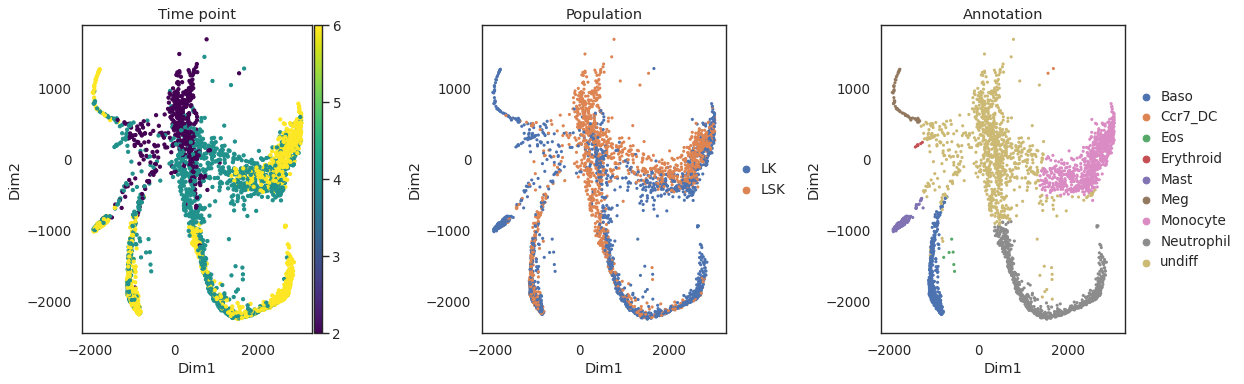

In [9]:
me.pl.scatter(adata, 
              color=['Time point','Population','Annotation'],
              drawing_order='random',
              obsm='X_SPRING')

# Calculate clonal trajectory distances

In [10]:
me.tl.clone_distance(adata,
                     method='geodesic',
                     obsm='X_SPRING',
                     anno_time='Time point',
                     n_jobs=4)

Finished: 0.5064414620399476 mins


In [11]:
adata.uns['clone'].keys()

dict_keys(['anno', 'distance_geodesic', 'distance'])

In [12]:
me.tl.cluster_clones(adata,
                     n_clusters=6,
                     method='hierarchical')

In [13]:
adata.uns['clone']['anno'].head()

,hierarchical
50,5
82,6
105,3
111,5
134,4


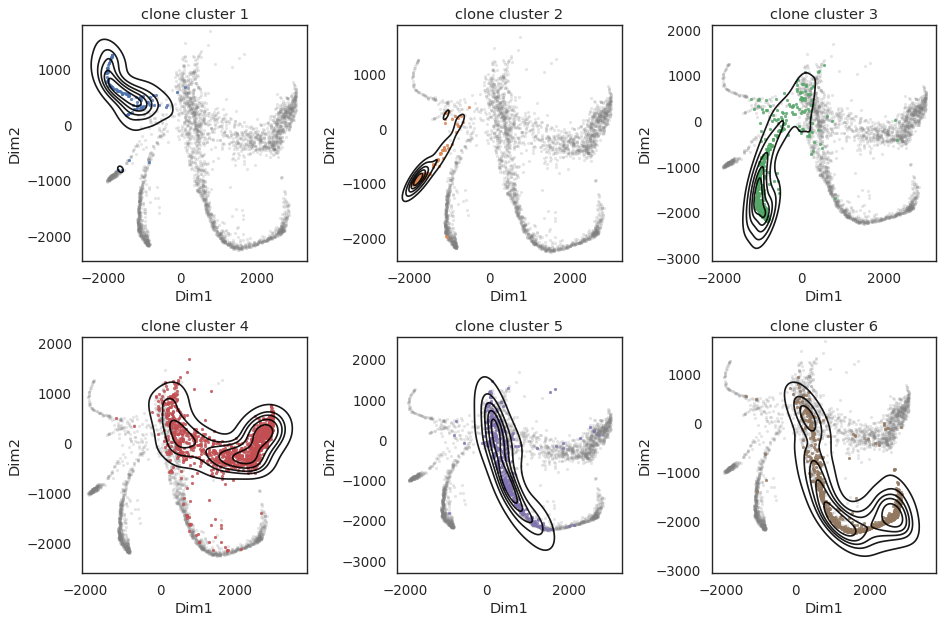

In [14]:
me.pl.clone_clusters(adata, group='hierarchical', obsm='X_SPRING',show_contour=True, 
                    levels=6, thresh=0.1)

# Compare our distance calculations to a ground truth

In [15]:
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score

df_truth = pd.read_csv('./larry_input/subset/clones_truth.tsv.gz',sep='\t',index_col=0)
all(df_truth.index.astype(str) == adata.uns['clone']['anno'].index)

True

In [16]:
adjusted_rand_score(df_truth['celltype'].tolist(),  adata.uns['clone']['anno']['hierarchical'].tolist())

0.8240474981576086

# Identify genes differentially expressed between clone cluster 4 and clone cluster 6

graph already built, using previous (set force=True to clobber)


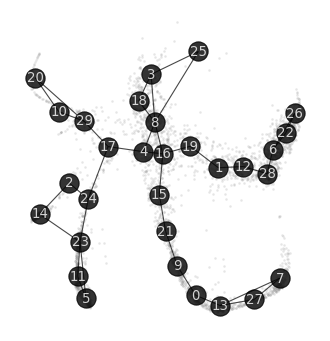

In [87]:
me.tl.build_graph(adata, obsm='X_SPRING', k=3, n_clusters=30)
me.pl.cluster_graph(adata, obsm='X_SPRING', node_color="black", alpha=0.8)


graph already built, using previous (set force=True to clobber)


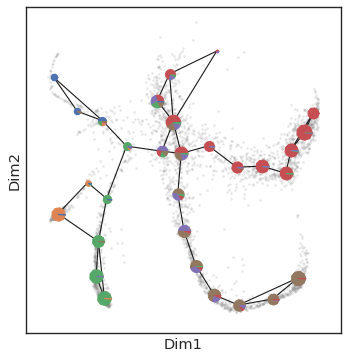

In [18]:
me.pl.cluster_pie_graph(adata, obsm='X_SPRING')

In [86]:
adata.clone

['clone',
 'cluster_edgelist',
 'cluster_pdist',
 'cluster_pos',
 'cluster_pseudotime',
 'color']

In [96]:
# progenitor_clusters = [3, 18, 8]
progenitor_clusters = [3]

me.tl.calculate_pseudotime(adata, progenitor_clusters)

84        6
115       8
190       6
205       6
337       5
         ..
130563    6
130686    8
130735    6
130740    5
130772    8
Name: pseudotime, Length: 3221, dtype: int64

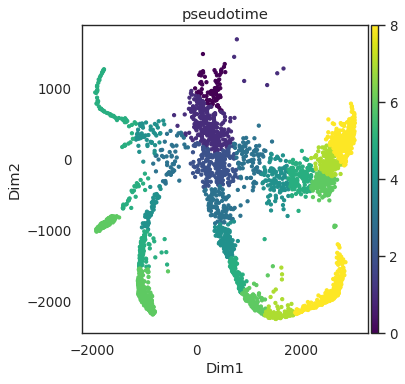

In [98]:
# adata.obsm['umap'] = adata.obsm['X_SPRING']
me.pl.scatter(adata,obsm='X_SPRING',color=['pseudotime'])

In [99]:
adata.obs

,Time point,Population,Annotation,Well,cluster,metaclone,pseudotime
84,6.0,LK,Mast,2,14,2,6
115,6.0,LK,Monocyte,2,26,4,8
190,6.0,LK,Mast,2,14,2,6
205,6.0,LK,Mast,2,14,2,6
337,6.0,LK,Meg,2,20,1,5
...,...,...,...,...,...,...,...
130563,6.0,LSK,Neutrophil,1,0,5,6
130686,6.0,LSK,Monocyte,1,22,4,8
130735,6.0,LSK,Neutrophil,1,0,6,6
130740,6.0,LSK,Monocyte,1,12,4,5


In [21]:
progenitor_cells = adata[adata.obs['pseudotime'] <= 1]
progenitor_cells.obs

,Time point,Population,Annotation,Well,cluster,metaclone,pseudotime
13199,2.0,LK,undiff,0,8,4,1
13614,2.0,LK,undiff,0,8,4,1
13742,2.0,LK,undiff,0,8,4,1
13887,2.0,LK,undiff,0,18,6,1
14363,2.0,LK,undiff,0,8,6,1
...,...,...,...,...,...,...,...
107235,4.0,LSK,undiff,2,8,4,1
108138,4.0,LSK,undiff,2,8,4,1
108296,4.0,LSK,undiff,2,8,5,1
110161,4.0,LSK,undiff,2,25,4,1


In [22]:
group1 = ['4'] # the first metaclone to test against
group2 = ['6'] # the second metaclone to test against

# me.tl.differential_test_vars(progenitor_cells, group1, group2, test="t-test", n_jobs=8)
# ttest_results = progenitor_cells.uns['t-test_MEGATRON'].set_index('gene')
# ttest_results

In [23]:
me.tl.differential_test_vars(progenitor_cells, group1, group2, test="wilcoxon", n_jobs=8)
wilcoxon_results = progenitor_cells.uns['wilcoxon_MEGATRON'].set_index('gene')
wilcoxon_results.head(10)

Trying to set attribute `._uns` of view, copying.


,coef,p_value,p_value_corr
gene,,,
Elane,-4.025697,1.204974e-14,3.047258e-10
Srgn,-8.931299,1.013017e-10,1.280910e-06
Ctsg,-3.027029,2.773660e-09,2.338103e-05
Dstn,-0.532065,8.774783e-09,5.163156e-05
Arl11,-0.220759,1.020830e-08,5.163156e-05
Gfi1,-0.211798,4.382407e-08,1.583842e-04
Cd63,-0.510710,4.384079e-08,1.583842e-04
Hk3,-0.508590,6.207790e-08,1.962360e-04
Plod3,-0.354769,7.051724e-08,1.981456e-04


In [24]:
top_hits = wilcoxon_results.query('p_value_corr<0.01 and abs(coef)>2')
top_hits

,coef,p_value,p_value_corr
gene,,,
Elane,-4.025697,1.204974e-14,3.047258e-10
Srgn,-8.931299,1.013017e-10,1.280910e-06
Ctsg,-3.027029,2.773660e-09,2.338103e-05
H2afy,6.290673,1.175420e-07,2.698614e-04
mt-Co2,15.306557,1.366636e-06,1.329263e-03
Calr,-2.829855,3.056787e-06,2.202082e-03
Ccdc62,-2.555109,3.676363e-06,2.512744e-03


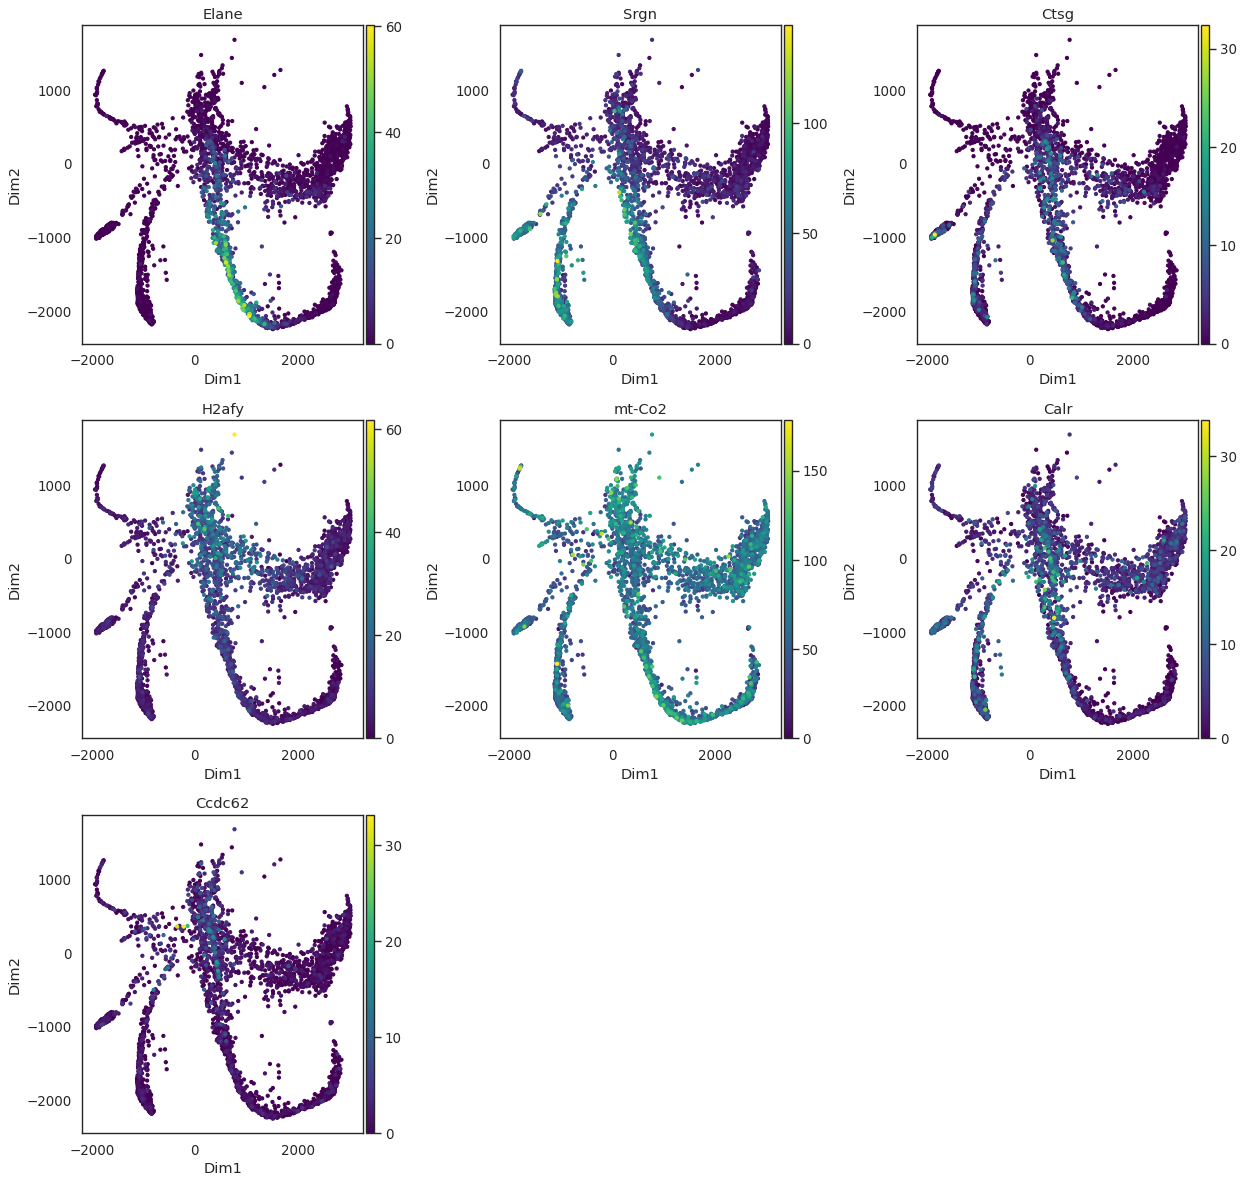

In [25]:
me.pl.scatter(adata, obsm='X_SPRING', color=top_hits.index[:9])

In [54]:
var_subset = top_hits.index[:6]


def get_obs_by_metaclone(adata, var_subset=None, metaclone_subset=None):

    if var_subset is None:
            var_subset = adata.var_names

    metaclones = sorted(pd.unique(adata.uns['clone']['anno']['hierarchical']))

    if metaclone_subset is None:
        metaclone_subset = metaclones
    
    clone_x_metaclone = pd.get_dummies(adata.uns['clone']['anno']).values
    cell_x_clone = adata.obsm['X_clone']
    cell_x_metaclone = (cell_x_clone @ clone_x_metaclone).astype(bool)
    n_cells, n_metaclones = cell_x_metaclone.shape
    
    def _get_metaclone_observations(j):
        if metaclones[j] not in metaclone_subset:
            return None
        
        adata_subset = adata[:,var_subset][cell_x_metaclone[:,j],:]
        subset_df = pd.DataFrame(adata_subset.X.todense(), columns=list(var_subset))
        if 'pseudotime' in adata_subset.obs_keys():
            subset_df=subset_df.assign(pseudotime=adata_subset.obs['pseudotime'].values)
        # subset_df=subset_df.melt(id_vars=['pseudotime'], var_name='gene').assign(metaclone=metaclones[j])
        return subset_df

    return pd.concat(map(_get_metaclone_observations, range(n_metaclones))).reset_index(drop=True)
# len(adata)
get_obs_by_metaclone(adata, var_subset=var_subset)

,Elane,Srgn,Ctsg,H2afy,mt-Co2,Calr,pseudotime
0,0.000000,6.047792,0.000000,1.295955,39.742634,4.319851,5
1,0.000000,9.081227,0.000000,3.027076,0.000000,0.000000,5
2,0.000000,0.000000,0.000000,0.000000,54.573441,0.000000,5
3,0.000000,3.149616,1.574808,0.000000,36.220585,0.000000,5
4,0.421548,40.890125,0.000000,1.686191,44.684052,0.843095,6
...,...,...,...,...,...,...,...
3216,22.475594,17.793179,1.872966,2.809449,43.078220,1.872966,6
3217,10.023499,3.341166,2.004700,3.341166,44.103397,0.000000,6
3218,0.000000,0.000000,0.000000,4.422041,26.532249,0.000000,8
3219,3.029199,8.077865,0.000000,2.019466,37.360123,1.009733,6


In [56]:
%load_ext autoreload
%autoreload 2

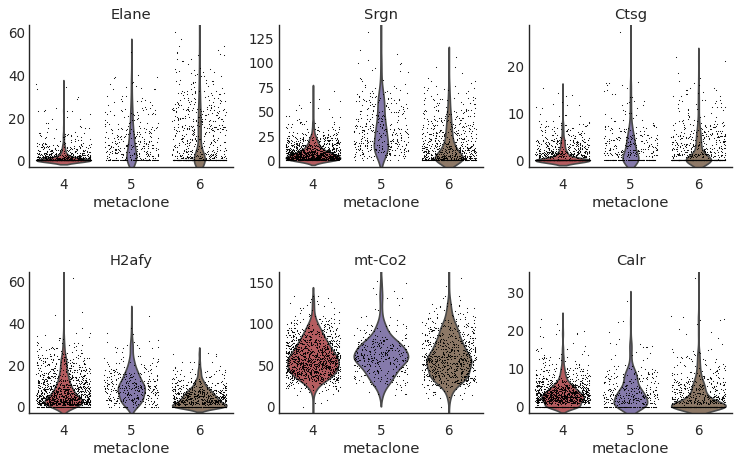

In [83]:
me.pl.metaclone_violin(adata, list_var=var_subset, list_metaclone=['4','5','6'])# adata.var_names

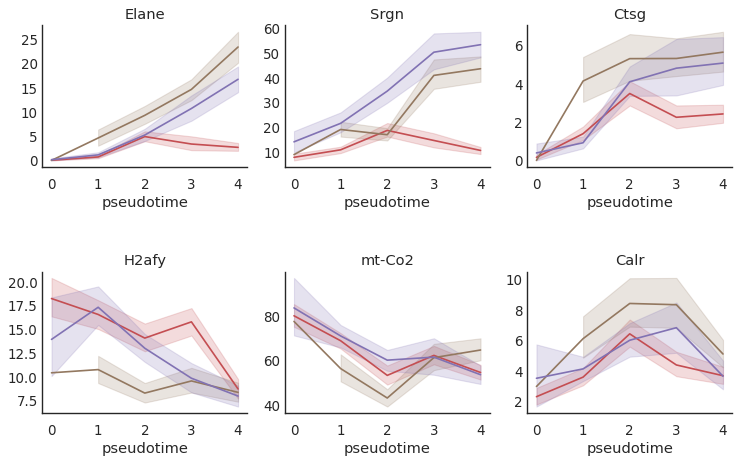

In [116]:
me.pl.metaclone_lineplot(adata, list_var=var_subset,
                         list_metaclone=['4','5','6'], max_pseudotime=4)

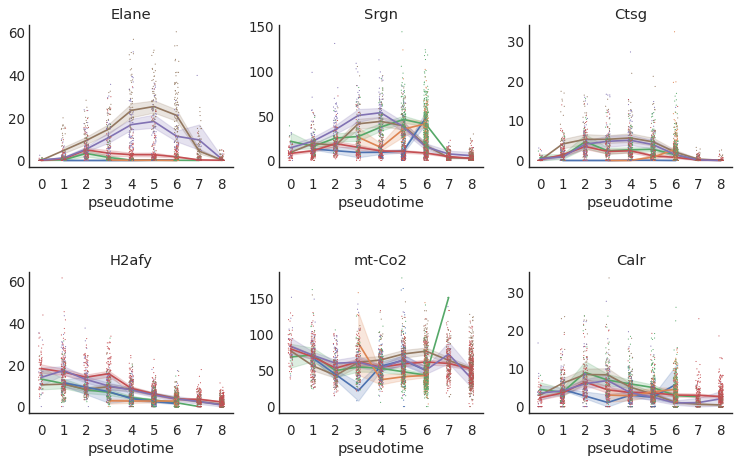

In [112]:
me.pl.metaclone_lineplot(adata, list_var=var_subset)